In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as ss
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from par2vec.common import *

/home/govert/anaconda3/envs/pytorch-par2vec/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Load Reuters

In [3]:
# Load tokenized reuters
topic2id = np.load('data/reuters/reuters_topic2id.npy').item(0)
id2topic = np.load('data/reuters/reuters_id2topic.npy').item(0)
topics = list(np.load('data/reuters/reuters_topics.npy'))

word2id = np.load('data/reuters/reuters_word2id.npy').item(0)
id2word = np.load('data/reuters/reuters_id2word.npy').item(0)
tokenized = list(np.load('data/reuters/reuters_tokenized.npy'))

### Compute document graphs and essentials

In [ ]:
# Create graphs for N documents
N=100000
max_w=13

counts = np.zeros((N, max_w))
entropies = []
for i, (_, A_o, A_i, _, _) in enumerate(get_lapl(tokenized[:N], word2id)):
    print ('\r %d/%d' % (i+1, N), end='')
    if (i+1 % 1000) == 0:
        print('\n {}/{} \n'.format(i, N))
        
    # Graph
    A = (A_o + A_i).data
    
    # Weight counts
    bincount = np.bincount(A.astype(int))
    for j in range(min(len(bincount), max_w)):
        counts[i, j] = bincount[j]
        
    # Entropies
    entropies.append(sp.stats.entropy((A_o + A_i).data))
    

# Parse data
x = np.arange(1, max_w)
y_mean = np.mean(counts[:,1:], axis=0)
y_std = np.std(counts[:,1:], axis=0)

### Plot distribution of non-zero graph weights

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Distribution of non-zero graph weights')
plt.xlabel('Weight')
plt.ylabel('Average Count')
plt.yscale('log')
plt.errorbar(x, y_mean, yerr=y_std)
plt.savefig('plots/dist_nonzero_graph_weights.png')
plt.show()

### Plot distribution graph entropies 

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Distribution of graph entropies')
plt.xlabel('Entropy')
plt.ylabel('Occurence')
sns.distplot(ents, bins=50)
plt.savefig('plots/dist_graph_entropies.png')
plt.show()

### Plot distribution of topics

In [ ]:
topic_count = [len(x) for x in topics]
plt.xlabel('# Topics per document')
plt.ylabel('Amount of Documents')
sns.distplot(topic_count, kde=False, )
plt.savefig('plots/dist_topics_over_docs.png')
plt.show()

### Plot class imbalance

In [ ]:
flat_topics = [item for sublist in topics for item in sublist]
topic_i, topic_count = np.unique(flat_topics, return_counts=True)
print('Counts per class:', y)
plt.bar(x, y)
plt.savefig('plots/dist_topic_counts.png')
plt.show()

In [ ]:
id2topic[x[np.argmax(y)]]

### Report Plots

In [4]:
def gen_doc_topic(dim_t=30, dim_d=16):
    num_t = np.random.randint(1,np.minimum(dim_t, 3))
    ts = np.random.choice(dim_t, num_t, replace=False)
    ts_boost = np.random.rand(np.shape(ts)[0])*3. + 0.5
    ts_boost = ts_boost[np.newaxis,:, np.newaxis]
    d = np.random.rand(1,dim_t, dim_d)
    d[...,ts, :]*= ts_boost
    return d
    
num_docs, dim_t, dim_d = 100, 30, 16
docs = np.zeros((num_docs, dim_t, dim_d))
for d in range(num_docs):
    docs[d,:,:] = gen_doc_topic(dim_t, dim_d)

In [7]:
topic_doc = np.zeros((len(topics), 135))
for i, topic in enumerate(topics):
    topic_doc[i][topic] = 1

In [20]:
# for i, k in enumerate(np.sum(topic_doc, axis=0).astype(int)):
#      print(i, k)
topic_doc[:, 81]>0
#81 en 74

187


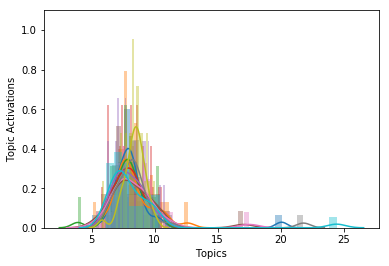

In [3]:
for d in docs[:10]:
    sns.distplot(np.sum(d,1), bins=dim_t, hist=True, norm_hist=True)
    
plt.xlabel('Topics')
plt.ylabel('Topic Activations')
plt.ylim([0.,1.1])
plt.show()

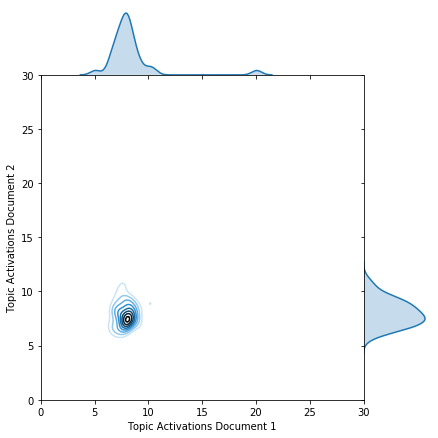

In [23]:
fig = sns.jointplot(x=np.sum(docs[np.random.randint(dim_d)], 1), 
                    y=np.sum(docs[np.random.randint(dim_d)],1), 
                    kind="kde", space=0, stat_func=None, xlim=(0,30),ylim=(0,30), shade=False);
fig.set_axis_labels('Topic Activations Document 1', 'Topic Activations Document 2')
plt.show()

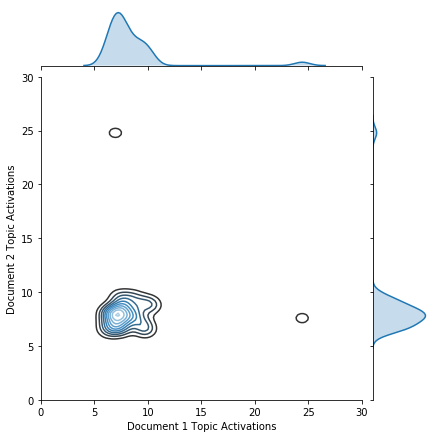

In [22]:
d1 = np.sum(docs[np.random.randint(dim_d)], 1)
d2 = np.sum(docs[np.random.randint(dim_d)], 1)
g = sns.JointGrid(x=d1, y=d2, xlim=(0, 30), ylim=(0, 30))
g = g.plot_joint(sns.kdeplot, cmap="Blues_d")
g = g.plot_marginals(sns.kdeplot, shade=True)
g.set_axis_labels('Document 1 Topic Activations', 'Document 2 Topic Activations')